In [2]:
import pandas as pd
import re
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from math import radians, sin, cos, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
InteractiveShell.ast_node_interactivity ='all'

pd.set_option('display.max_columns', None)    #显示所有列
pd.set_option('display.max_rows', 30)    #显示所有行
pd.set_option('max_colwidth',100)    #设置value的显示长度为100，默认为50

# 0. Pre_processing

In [2]:
dispatch_init = pd.read_csv('dispatch_info.csv', encoding = 'utf-8').fillna('0')
dispatch_init = dispatch_init[dispatch_init['RECEIVE_PROVINCE'] != dispatch_init['FROM_PROVINCE']]
dispatch_init.shape
dispatch_init.head(1)

(618410, 26)

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT
43,LO2019010130861655,Z121812072967,T1812314350909,合肥美的电冰箱有限公司-内销,冰箱事业部,0.932393,76.0,1.0,云南省,昆明市,官渡区,阿拉街道,普照村大麻苴马帮物流园内安得物流,湖北省,荆州市,沙市区,轻货,B,2019-01-03 08:35:31,2019-01-04 23:44:19,鄂DB5788,17.5米车,罗学忠,0.932393,102.804,25.0146


### 0.1 地址统一

In [3]:
my_add = pd.read_excel('最后的地址汇总.xlsx')
your_add = pd.read_excel('res.xlsx')
my_add = my_add[['RECEIVE_CITY', 'extract_address', 'unique_address']]
final_add = pd.concat([my_add, your_add], ignore_index=True)

def replace_add(x, add_dict):
    receive_address = str(x['RECEIVE_ADDRESS'])
    values = None
    for k, v in add_dict.items():
        if k in receive_address:
            values = v
            return values
        else:
            values = receive_address
    return values

df_1= pd.DataFrame()
for name, df_group in dispatch_init.groupby("RECEIVE_CITY"):                           # 遍历分组后的城市
    add = final_add[final_add['RECEIVE_CITY'] == name]
    add_dict = dict(zip(add['extract_address'], add['unique_address']))     # 把近似地址映射成唯一地址，构建多对一词典
    df_group['FIX_ADDRESS'] = df_group.apply(lambda x: replace_add(x, add_dict), axis=1)
    df_1 = df_1.append(df_group)                                 # 将填充后的组合并到df_fix_add中
df_1 = df_1.fillna('0')
df_1['FIX_ADDRESS'] = df_1.apply(lambda x: x['RECEIVE_ADDRESS'] if x['FIX_ADDRESS'] == '0'
                                 else x['FIX_ADDRESS'] , axis = 1)
df_1.head(1)

/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,FIX_ADDRESS
2117,LO2019010130888733,Z101812062980,T1901014358395,广东美的制冷设备有限公司-国内营销,家用空调事业部,60.55344,8185.5,214.0,上海市,上海市辖区,金山区,金山卫镇,金舸路188号上海金山工业园区物流园,湖北省,武汉市,蔡甸区,轻货,B,2019-01-03 19:44:08,2019-01-04 15:09:21,皖C79586,17.5米车,杨升,60.55344,121.346,30.8022,金舸路188号上海金山工业园区物流园


###  0.2 卸货时间计算

In [4]:
df_2 = df_1
df_2 = df_2[df_2['ORDER_NO'] != 'LO2019051236320475']
df_2 = df_2[df_2['DO_NO']!= '0']
df_2[['PICK_UP_TIME','RECEIVE_TIME']] = df_2[['PICK_UP_TIME','RECEIVE_TIME']].astype('datetime64')

df_2  = pd.merge(df_2, df_2.groupby(['DO_NO','FIX_ADDRESS']
                )['PICK_UP_TIME'].min().reset_index().rename(columns = {'PICK_UP_TIME':'PICK_UP_EARLIST'}
                ), how = 'left', on = ['DO_NO','FIX_ADDRESS']) #最早的到达时间
df_2  = pd.merge(df_2, df_2.groupby(['DO_NO','FIX_ADDRESS']
                )['RECEIVE_TIME'].max().reset_index().rename(columns = {'RECEIVE_TIME':'RECEIVE_LATEST'}
                ), how = 'left', on = ['DO_NO','FIX_ADDRESS']) #最晚的离开时间
df_2['UNLOAD_TIME'] = df_2.apply(lambda x: (x['RECEIVE_LATEST'] - x['PICK_UP_EARLIST']).total_seconds()/3600, axis = 1 )
df_2.head(1)
df_2.shape

,ORDER_NO,SO_NO,DO_NO,CUSTOMER,BU_NAME,VOLUME,WEIGHT,QUANTITY,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,RECEIVE_STREET,RECEIVE_ADDRESS,FROM_PROVINCE,FROM_CITY,FROM_DISTRICT,FREIGHT_BASIS,BUSINESS_TYPE,PICK_UP_TIME,RECEIVE_TIME,LICENSE,EQUIPMENT,DRIVER,RECEIVE_VOLUME,ARRIVAL_LNG,ARRIVAL_LAT,FIX_ADDRESS,PICK_UP_EARLIST,RECEIVE_LATEST,UNLOAD_TIME
0,LO2019010130888733,Z101812062980,T1901014358395,广东美的制冷设备有限公司-国内营销,家用空调事业部,60.55344,8185.5,214.0,上海市,上海市辖区,金山区,金山卫镇,金舸路188号上海金山工业园区物流园,湖北省,武汉市,蔡甸区,轻货,B,2019-01-03 19:44:08,2019-01-04 15:09:21,皖C79586,17.5米车,杨升,60.55344,121.346,30.8022,金舸路188号上海金山工业园区物流园,2019-01-03 19:44:08,2019-01-04 15:09:21,19.420278


(618377, 30)

### 0.3 异常数据处理

In [8]:
df_3 = pd.DataFrame(df_2.groupby(['ORDER_NO'])['FIX_ADDRESS'].nunique().reset_index()).rename(columns={'FIX_ADDRESS':'COUNT'})
df_3 = df_3[df_3['COUNT'] == 1]
df_2 = pd.merge(df_3[['ORDER_NO']].drop_duplicates(), df_2, how = 'left', on ='ORDER_NO')

#对于订单体积等于入库体积的，对同一物流订单，总体积，总重量，总数量，入库体积相同，收货地不同的样本，删除统计数目大于2的样本
df_3 = df_2[df_2['VOLUME'] == df_2['RECEIVE_VOLUME']]         #入库和订单体积相同
df_3 = pd.DataFrame(df_2.groupby(['ORDER_NO', 'RECEIVE_VOLUME'])['RECEIVE_ADDRESS'].nunique()
                   ).reset_index().rename(columns = {'RECEIVE_ADDRESS': 'MARK'})
df_3 = df_3[df_3['MARK'] == 1]
df_3 = pd.merge(df_3[['ORDER_NO']], df_2, on = 'ORDER_NO', how = 'left')
# df_3 = pd.concat([df_2[df_2['VOLUME'] != df_2['RECEIVE_VOLUME']], df_3])   #入库和订单体积不同的并入
df_3.shape

(617627, 30)

In [9]:
#对于入库体积不等于订单体积的入进行数值累加
df_4 = df_2[df_2['VOLUME'] != df_2['RECEIVE_VOLUME']] 
df_4 = pd.DataFrame(df_4.groupby(['DO_NO', 'PICK_UP_EARLIST','RECEIVE_VOLUME', 'FIX_ADDRESS','CUSTOMER','BU_NAME',
    'RECEIVE_PROVINCE', 'RECEIVE_CITY', 'RECEIVE_DISTRICT','BUSINESS_TYPE','FREIGHT_BASIS', 'LICENSE', 'EQUIPMENT', 
    'DRIVER']).agg({'VOLUME':'sum', 'WEIGHT':'sum', 'QUANTITY':'sum', 'UNLOAD_TIME': 'sum'})).reset_index()
df_4 = df_4[df_4['VOLUME'] == df_4['RECEIVE_VOLUME']]

df_3 = df_3[['DO_NO', 'PICK_UP_EARLIST', 'RECEIVE_VOLUME', 'FIX_ADDRESS','CUSTOMER','BU_NAME','RECEIVE_PROVINCE', 'RECEIVE_CITY', 
        'RECEIVE_DISTRICT', 'BUSINESS_TYPE','FREIGHT_BASIS', 'LICENSE', 'EQUIPMENT','DRIVER', 'VOLUME', 'WEIGHT',
       'QUANTITY', 'UNLOAD_TIME']]
df_3 = pd.concat([df_3, df_4])
df_3.shape
df_3.head(1)

(636816, 18)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME
0,T1812314350909,2019-01-03 08:35:31,0.932393,大麻苴村马帮物流园（东方仓）,合肥美的电冰箱有限公司-内销,冰箱事业部,云南省,昆明市,官渡区,B,轻货,鄂DB5788,17.5米车,罗学忠,0.932393,76.0,1.0,39.146667


### 0.4 异常体积重量

In [10]:
df_4 = df_3
df_4['UNIT_VOLUME_WEIGHT'] = df_4['WEIGHT']/df_4['VOLUME']
def box_plot(df):
#     df = df[df['UNIT_VOLUME_WEIGHT'] != 0]
    Ser = df['UNIT_VOLUME_WEIGHT']
    Low = Ser.quantile(0.25)-1.5*(Ser.quantile(0.75)-Ser.quantile(0.25))
    Up = Ser.quantile(0.75)+1.5*(Ser.quantile(0.75)-Ser.quantile(0.25))
#     Mid = Ser.quantile(0.5)
    df = df[(df['UNIT_VOLUME_WEIGHT'] > Low) & (df['UNIT_VOLUME_WEIGHT'] < Up)]
    Mean = np.mean(df['UNIT_VOLUME_WEIGHT'])
    return Low, Up, Mean

Low_1 , Up_1, Mean_1 = box_plot(df_3[df_3['FREIGHT_BASIS'] == '轻货'])
Low_2 , Up_2, Mean_2 = box_plot(df_3[df_3['FREIGHT_BASIS'] == '重货'])

df_4['FIX_WEIGHT'] = df_4.apply(lambda x: x.VOLUME * Mean_1 if (x.UNIT_VOLUME_WEIGHT < Low_1) & (x.FREIGHT_BASIS == '轻货')
                               else x.VOLUME * Mean_2  if (x.UNIT_VOLUME_WEIGHT < Low_2) & (x.FREIGHT_BASIS == '重货')
                               else x.WEIGHT, axis = 1)
df_4['FIX_VOLUME'] = df_4.apply(lambda x: x.WEIGHT / Mean_1 if (x.UNIT_VOLUME_WEIGHT > Up_1) & (x.FREIGHT_BASIS == '轻货')
                               else x.WEIGHT / Mean_2 if (x.UNIT_VOLUME_WEIGHT > Up_2) & (x.FREIGHT_BASIS == '重货')
                               else x.VOLUME, axis =1)
df_4.head(1)
df_4.shape

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,UNIT_VOLUME_WEIGHT,FIX_WEIGHT,FIX_VOLUME
0,T1812314350909,2019-01-03 08:35:31,0.932393,大麻苴村马帮物流园（东方仓）,合肥美的电冰箱有限公司-内销,冰箱事业部,云南省,昆明市,官渡区,B,轻货,鄂DB5788,17.5米车,罗学忠,0.932393,76.0,1.0,39.146667,81.510693,76.0,0.932393


(636816, 21)

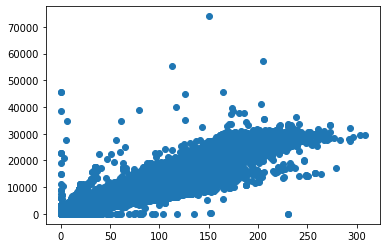

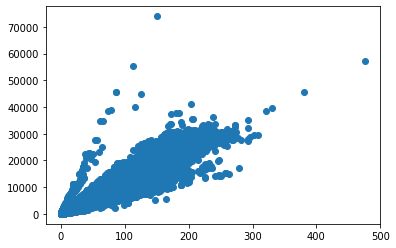

In [11]:
plt.scatter(df_3['VOLUME'], df_3['WEIGHT'])
plt.show()
plt.scatter(df_4['FIX_VOLUME'], df_4['FIX_WEIGHT'])
plt.show()

In [12]:
df_5 = df_4[(df_4['VOLUME'] > 250) & (df_4['WEIGHT'] > 55000)]
df_5['TAG'] = 1
df_4 = pd.merge(df_4, df_5[['DO_NO','TAG']].drop_duplicates(), on = 'DO_NO', how = 'left').fillna(0)

df_5 = df_4[(df_4['FIX_VOLUME'] > 250) & (df_4['FIX_WEIGHT'] > 55000)]
df_5['FIX_TAG'] = 1
df_4 = pd.merge(df_4, df_5[['DO_NO','FIX_TAG']].drop_duplicates(), on = 'DO_NO', how = 'left').fillna(0)

df_4.shape
df_4.head(1)

/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(636816, 23)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,UNIT_VOLUME_WEIGHT,FIX_WEIGHT,FIX_VOLUME,TAG,FIX_TAG
0,T1812314350909,2019-01-03 08:35:31,0.932393,大麻苴村马帮物流园（东方仓）,合肥美的电冰箱有限公司-内销,冰箱事业部,云南省,昆明市,官渡区,B,轻货,鄂DB5788,17.5米车,罗学忠,0.932393,76.0,1.0,39.146667,81.510693,76.0,0.932393,0.0,0.0


# 1. 数据聚合

### 1.1 数据聚合(df_5)

In [13]:
df_4.shape
df_4 = df_4.groupby(['DO_NO','PICK_UP_EARLIST', 'RECEIVE_VOLUME', 'FIX_ADDRESS', 'CUSTOMER', 'BU_NAME','RECEIVE_PROVINCE', 
                     'RECEIVE_CITY', 'RECEIVE_DISTRICT', 'BUSINESS_TYPE','FREIGHT_BASIS', 'LICENSE', 'EQUIPMENT', 
                     'DRIVER', 'TAG', 'FIX_TAG']).agg({'VOLUME':'sum', 'WEIGHT':'sum', 'QUANTITY':'sum', 'UNLOAD_TIME':'sum',
                     'FIX_WEIGHT':'sum','FIX_VOLUME':'sum'}).reset_index()
df_4.shape
df_4.head(1)

(636816, 23)

(556373, 22)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.28,368.5,55.0,5.562778,368.5,5.28


# 2 特征处理

### 2.1 卸货时间归整（df_6）

In [14]:
df_5 = df_4[(df_4['UNLOAD_TIME'] > 0.25) & (df_4['UNLOAD_TIME'] < 72)]
df_5['UNLOAD_TIME_INT'] = df_5['UNLOAD_TIME'].apply(lambda x: 2 if x <= 2
                                                       else 4 if x <= 4
                                                       else 6 if x <= 6
                                                       else 8 if x <= 8
                                                       else 12 if x <= 12
                                                       else 18 if x <= 18
                                                       else 32 if x<= 32
                                                       else 48)
df_5.shape
df_5.head(1)

/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(518172, 23)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.28,368.5,55.0,5.562778,368.5,5.28,6


### 2.2 时间，季度，月

In [15]:
df_5['TIME'] = df_5['PICK_UP_EARLIST'].map(lambda x: 1 if x.hour <= 4 #'Late_Night'
                                          else 2 if x.hour <= 8 #'Early_morinig'
                                          else 3 if x.hour <= 12 #'Morning'
                                          else 4 if x.hour <= 14 #'Noon'
                                          else 5 if x.hour <= 19 #'Afternoon'
                                          else 6 ) #'Night'
df_5['RECEIVE_MONTH'] = df_5['PICK_UP_EARLIST'].map(lambda x: x.month)
df_5['RECEIVE_SEASON'] = df_5['RECEIVE_MONTH'].map(lambda x: 1 if (x >= 3) & (x <= 5) #春
                                                    else 2 if( x >= 6) & (x <= 8) #夏
                                                    else 3 if (x >= 9) & (x <= 11) #秋
                                                    else 4 ) #冬
df_5.head(1)

/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,TIME,RECEIVE_MONTH,RECEIVE_SEASON
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.28,368.5,55.0,5.562778,368.5,5.28,6,3,9,3


### 2.3 车长提取

In [16]:
def find_re(x):
    if "40GP(海运)" in x:
        return 12
    elif "40HQ(海运)" in x:
        return 12
    elif "45HQ(海运)" in x:
        return 13
    elif re.search( r"\d+\.?\d*", x):
        return re.search( r"\d+\.?\d*", x).group()
    else:
        return 0

df_5["VEHICLE_LENGTH"] = df_5["EQUIPMENT"].apply(lambda x: find_re(str(x)))
df_5.head(1)

/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,TIME,RECEIVE_MONTH,RECEIVE_SEASON,VEHICLE_LENGTH
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.28,368.5,55.0,5.562778,368.5,5.28,6,3,9,3,17.5


### 2.4 统一客户名称 

In [17]:
customer = pd.read_excel('customer_name.xlsx')
df_5 = pd.merge(df_5, customer, how='left', on=['CUSTOMER'])
df_5.head(1)
df_5.shape

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,TIME,RECEIVE_MONTH,RECEIVE_SEASON,VEHICLE_LENGTH,company
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.28,368.5,55.0,5.562778,368.5,5.28,6,3,9,3,17.5,无锡小天鹅股份有限公司-内销


(518172, 28)

### 重量，体积，数量离散化

In [18]:
df_5['VOLUME_LEVEL'] = df_5['FIX_VOLUME'].apply(lambda x: 1 if x <= 1.5
                                                       else 2 if x <= 3.5
                                                       else 3 if x <= 7
                                                       else 4 if x <= 13
                                                       else 5 if x <= 25
                                                       else 6 if x <= 50
                                                       else 7 )
df_5['RECEIVE_VOLUME_LEVEL'] = df_5['RECEIVE_VOLUME'].apply(lambda x: 1 if x <= 1.5
                                                       else 2 if x <= 3.5
                                                       else 3 if x <= 7
                                                       else 4 if x <= 13
                                                       else 5 if x <= 25
                                                       else 6 if x <= 50
                                                       else 7 )
df_5['WEIGHT_LEVEL'] = df_5['FIX_WEIGHT'].apply(lambda x: 1 if x <= 180
                                                       else 2 if x <= 430
                                                       else 3 if x <= 810
                                                       else 4 if x <= 1450
                                                       else 5 if x <= 2590
                                                       else 6 if x <= 5680
                                                       else 7 )
df_5['QUANTITY_LEVEL'] = df_5['QUANTITY'].apply(lambda x: 1 if x <= 8
                                                       else 2 if x <= 20
                                                       else 3 if x <= 30
                                                       else 4 if x <= 60
                                                       else 5 if x <= 100
                                                       else 6 if x <= 290
                                                       else 7 )
df_5.head(1)

,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,TIME,RECEIVE_MONTH,RECEIVE_SEASON,VEHICLE_LENGTH,company,VOLUME_LEVEL,RECEIVE_VOLUME_LEVEL,WEIGHT_LEVEL,QUANTITY_LEVEL
0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.28,368.5,55.0,5.562778,368.5,5.28,6,3,9,3,17.5,无锡小天鹅股份有限公司-内销,3,1,2,4


In [19]:
# df_5['VOLUME'].describe(percentiles=[.15, .3, .45, .6, .75, .9])
# df_5['FIX_VOLUME'].describe(percentiles=[.15, .3, .45, .6, .75, .9])

# df_5['WEIGHT'].describe(percentiles=[.15, .3, .45, .6, .75, .9])
# df_5['FIX_WEIGHT'].describe(percentiles=[.15, .3, .45, .6, .75, .9])

# df_5['QUANTITY'].describe(percentiles=[.15, .3, .45, .6, .75, .9])

In [20]:
df_5.to_csv('clean_data.csv', encoding = 'gbk')

# 3. 模型建立

In [9]:
df = pd.read_csv('clean_data.csv', encoding = 'gbk')

In [12]:
df.columns

Index(['Unnamed: 0', 'DO_NO', 'PICK_UP_EARLIST', 'RECEIVE_VOLUME',
       'FIX_ADDRESS', 'CUSTOMER', 'BU_NAME', 'RECEIVE_PROVINCE',
       'RECEIVE_CITY', 'RECEIVE_DISTRICT', 'BUSINESS_TYPE', 'FREIGHT_BASIS',
       'LICENSE', 'EQUIPMENT', 'DRIVER', 'TAG', 'FIX_TAG', 'VOLUME', 'WEIGHT',
       'QUANTITY', 'UNLOAD_TIME', 'FIX_WEIGHT', 'FIX_VOLUME',
       'UNLOAD_TIME_INT', 'TIME', 'RECEIVE_MONTH', 'RECEIVE_SEASON',
       'VEHICLE_LENGTH', 'company', 'VOLUME_LEVEL', 'RECEIVE_VOLUME_LEVEL',
       'WEIGHT_LEVEL', 'QUANTITY_LEVEL'],
      dtype='object')

In [13]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder().fit(df['BU_NAME'])
df['BU_NO'] = encoder.transform(df['BU_NAME'])

encoder= LabelEncoder().fit(df['FIX_ADDRESS'])
df['ADDRESS_NO'] = encoder.transform(df['FIX_ADDRESS'])

encoder= LabelEncoder().fit(df['RECEIVE_PROVINCE'])
df['PROVINCE_NO'] = encoder.transform(df['RECEIVE_PROVINCE'])

encoder= LabelEncoder().fit(df['LICENSE'])
df['LICENSE_NO'] = encoder.transform(df['LICENSE'])

encoder= LabelEncoder().fit(df['FREIGHT_BASIS'])
df['FREIGHT_BASIS_NO'] = encoder.transform(df['FREIGHT_BASIS'])

encoder= LabelEncoder().fit(df['company'])
df['COMPANY_NO'] = encoder.transform(df['company'])

df.head(1)

,Unnamed: 0,DO_NO,PICK_UP_EARLIST,RECEIVE_VOLUME,FIX_ADDRESS,CUSTOMER,BU_NAME,RECEIVE_PROVINCE,RECEIVE_CITY,RECEIVE_DISTRICT,BUSINESS_TYPE,FREIGHT_BASIS,LICENSE,EQUIPMENT,DRIVER,TAG,FIX_TAG,VOLUME,WEIGHT,QUANTITY,UNLOAD_TIME,FIX_WEIGHT,FIX_VOLUME,UNLOAD_TIME_INT,TIME,RECEIVE_MONTH,RECEIVE_SEASON,VEHICLE_LENGTH,company,VOLUME_LEVEL,RECEIVE_VOLUME_LEVEL,WEIGHT_LEVEL,QUANTITY_LEVEL,BU_NO,ADDRESS_NO,PROVINCE_NO,LICENSE_NO,FREIGHT_BASIS_NO,COMPANY_NO
0,0,T1702111035440,2019-09-08 11:29:35,1.324772,陆路港物流装备产业园美安物流园,无锡小天鹅股份有限公司-内销,洗衣机事业部,天津市,天津市辖区,北辰区,B,轻货,皖C66478,17.5米车,崔海将,0.0,0.0,5.280000,368.5,55.0,5.562778,368.5,5.280000,6,3,9,3,17.5,无锡小天鹅股份有限公司-内销,3,1,2,4,5,653,6,6013,0,11
1,1,T1702111035818,2019-09-08 11:29:35,0.047530,亭湖区仓头村海龙机械厂向西100米,无锡小天鹅股份有限公司-内销,洗衣机事业部,江苏省,盐城市,亭湖区,B,轻货,苏H12740,17.5米车,安建喜,0.0,0.0,37.077512,2204.0,100.0,5.555278,2204.0,37.077512,6,3,9,3,17.5,无锡小天鹅股份有限公司-内销,6,1,5,5,5,79,14,10845,0,11
2,2,T1702111035868,2019-09-08 11:29:35,1.042770,通达灯塔仓库,无锡小天鹅股份有限公司-内销,洗衣机事业部,贵州省,铜仁市,碧江区,B,轻货,皖AA2888,17.5米车,刘邦胜,0.0,0.0,1.489413,84.0,3.0,5.558889,84.0,1.489413,6,3,9,3,17.5,无锡小天鹅股份有限公司-内销,1,1,1,1,5,610,24,5283,0,11
3,3,T1705261393528,2019-04-19 09:57:37,10.412280,水钢招待所,重庆美的通用制冷设备有限公司-工厂,中央空调事业部,贵州省,六盘水市,水城县,B,轻货,赣F29233,9.6米车,陶进海,0.0,0.0,1.708415,280.0,1.0,0.892222,280.0,1.708415,2,3,4,1,9.6,重庆美的通用制冷设备有限公司-工厂,2,4,2,1,0,373,24,13716,0,20
4,4,T1707271604891,2019-10-01 15:48:06,0.755710,昌东大道艾溪湖四路昌大瑞丰（国美仓库）,无锡小天鹅股份有限公司-内销,洗衣机事业部,江西省,南昌市,南昌县,B,轻货,皖KK6562,17.5米车,张洪强,0.0,0.0,24.304900,3900.0,50.0,0.746389,3900.0,24.304900,2,5,10,3,17.5,无锡小天鹅股份有限公司-内销,5,1,6,4,5,327,15,7036,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518167,518167,T2006158000048,2019-10-17 09:31:48,18.009000,大白庄镇九园公路南侧九园工业园内,合肥美的洗衣机有限公司-内销,洗衣机事业部,天津市,天津市辖区,宝坻区,B,轻货,皖A7L210,17.5米,郑诗胜,0.0,0.0,13.147950,1290.0,30.0,23.071111,1290.0,13.147950,32,3,10,3,17.5,合肥美的洗衣机有限公司-内销,5,5,4,3,5,204,6,4721,0,1
518168,518168,T2006168003800,2019-10-16 09:45:45,2.467500,齐河美安储运有限公司,合肥美的洗衣机有限公司-内销,洗衣机事业部,山东省,德州市,齐河县,B,轻货,冀J8N286,17.5米,杨立波,0.0,0.0,4.869240,450.0,10.0,49.643333,450.0,4.869240,48,3,10,3,17.5,合肥美的洗衣机有限公司-内销,3,2,3,2,5,706,9,1269,0,1
518169,518169,T2006168004609,2019-10-18 13:39:45,29.515968,秋湖路新丰家具厂内安得物流,合肥美的洗衣机有限公司-内销,洗衣机事业部,广东省,惠州市,惠阳区,B,轻货,皖S78289,17.5米,曹天飞,0.0,0.0,8.518380,800.0,20.0,18.968889,800.0,8.518380,32,4,10,3,17.5,合肥美的洗衣机有限公司-内销,4,6,3,2,5,487,11,8946,0,1
518170,518170,T2006168005918,2019-10-16 09:45:45,1.584490,淮上区康乐路18号棉麻公司大庆仓库,合肥美的洗衣机有限公司-内销,洗衣机事业部,安徽省,蚌埠市,淮上区,B,轻货,皖KP9897,17.5米,常亚林,0.0,0.0,15.306900,2340.0,30.0,49.643333,2340.0,15.306900,48,3,10,3,17.5,合肥美的洗衣机有限公司-内销,5,2,5,3,5,412,8,7323,0,1


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from xgboost import XGBClassifier
# 集成分类库和投票方法库
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, RandomForestClassifier
# StratifiedKFold：适用于有标签数据集的交叉检验数据集划分方法。cross_val_score：通过交叉检验方法做模型效果评估。导入交叉检验算法
from sklearn.model_selection import StratifiedKFold, cross_val_score

import time
startTime = time.time()

x = df[[ 'ADDRESS_NO','VEHICLE_LENGTH','PROVINCE_NO', 'RECEIVE_MONTH', 'RECEIVE_SEASON', 'TIME',
        'FREIGHT_BASIS_NO', 'VOLUME_LEVEL', 'WEIGHT_LEVEL', 'QUANTITY_LEVEL', 'BU_NAME', 'LICENSE_NO']]
y = df[['UNLOAD_TIME_INT']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
vec = DictVectorizer()
x_train = vec.fit_transform(x_train.to_dict(orient="record"))
x_test = vec.transform(x_test.to_dict(orient="record"))

rfc = RandomForestClassifier(n_jobs=-1, n_estimators = 100, max_depth = 17)
rfc.fit(x_train, y_train)
print("随机森林预测准确率:", rfc.score(x_test, y_test))

endTime = time.time()
print (endTime-startTime)

/Users/yuri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

随机森林预测准确率: 0.504811774695726
171.49705386161804


In [ ]:
xgbc = XGBClassifier()
xgbc.fit(x_train, y_train)
print("XGBoost预测准确率:", xgbc.score(x_test, y_test))

# 交叉检验
model_rf = RandomForestClassifier(max_features=0.8, random_state=0)  # 随机森林分类模型对象
model_gdbc = GradientBoostingClassifier(max_features=0.8, random_state=0)  # GradientBoosting分类模型对象
estimators = [('randomforest', model_rf), ('gradientboosting', model_gdbc)]  # 建立组合评估器列表
# voting：投放方法设置为soft，意味着使用每个分类器的概率做投票统计，最终按投票概率选出；还可以设置为hard，意味着通过每个分类器的label按得票最多的label做预测输出。
model_vot = VotingClassifier(estimators=estimators, voting='soft', weights=[0.9, 1.2], n_jobs=-1)  # 建立组合评估模型
cv = StratifiedKFold(7, shuffle=True, random_state=2)  # 设置交叉检验方法
cv_score = cross_val_score(model_gdbc, x_train, y_train, cv=cv)  # 交叉检验
print('{:*^60}'.format('Cross val scores:'), '\n', cv_score)  # 打印每次交叉检验得分
print('Mean scores is: %.2f' % cv_score.mean())  # 打印平均交叉检验得分